In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipdb
import os

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
import dan_models
import dan_utils
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

# Load data

In [5]:
class_set = [2, 3, 4]
randseed = 25
res = 11
v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res, randseed)
class_color_set = ['b', 'g', 'y', 'black', 'r']

# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_src = 3
v_class1 = v_class[class_src]  # source
near_road1 = np.array(near_road_set[class_src])

class_tar = 2
v_class2 = v_class[class_tar]  # target
near_road2 = np.array(near_road_set[class_tar])

num_links = v_class1.shape[0]

near_road_src = near_road1
flow_src = v_class1.iloc[:, 2:-1]
prop = 1  # proportion of training data
from_day = 1
to_day = 24

image_train_source, image_test_source, day_train_source, day_test_source, label_train_source, label_test_source\
= dan_utils.sliding_window(
    flow_src, near_road_src, from_day, to_day, prop, num_links
)

near_road_tar = near_road2
flow_tar = v_class2.iloc[:, 2:-1]
prop = 3/10
from_day = 22
to_day = 31

image_train_target, image_test_target, day_train_target, day_test_target, label_train_target, label_test_target\
= dan_utils.sliding_window(
    flow_tar, near_road_tar, from_day, to_day, prop, num_links
)

dup_mul = image_train_source.shape[0]//image_train_target.shape[0]
dup_r   = image_train_source.shape[0]%image_train_target.shape[0]

image_train_target, day_train_target, label_train_target = \
np.concatenate((np.tile(image_train_target, [dup_mul, 1, 1, 1]), image_train_target[:dup_r, :, :, :]), axis=0),\
np.concatenate((np.tile(day_train_target, [dup_mul, 1, 1]), day_train_target[:dup_r, :, :]), axis=0),\
np.concatenate((np.tile(label_train_target, [dup_mul, 1, 1]), label_train_target[:dup_r, :, :]), axis=0),



There are 5 class(es)


# Load model

In [9]:
t_input = image_train_source.shape[2]
t_pre = label_train_source.shape[2]
k = image_train_source.shape[1]

#模型构建
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

finish_model = dan_models.build_model(input_data, input_HA)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 5, 12, 40)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 12, 40)    160         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 12, 40)    14440       batch_normalization[0][0]        
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 5, 12, 40)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
#参数加载
finish_model.load_weights('../model/transfer_DAN_black_y_mape=0.17822_nrmse=0.07493.h5')
#模型预测
model_pre = finish_model.predict([image_test_target, day_test_target])

In [11]:
m = 5
print(dan_utils.mape_loss_func(model_pre, label_test_target, m))
print(dan_utils.smape_loss_func(model_pre, label_test_target, m))
print(dan_utils.nrmse_loss_func(model_pre, label_test_target, m))
print(dan_utils.mae_loss_func(model_pre, label_test_target, m))

0.17417744876888902
0.16155152675114964
0.07420658926701826
56.434408815127966


In [12]:
model_pre.shape

(706, 40, 6)

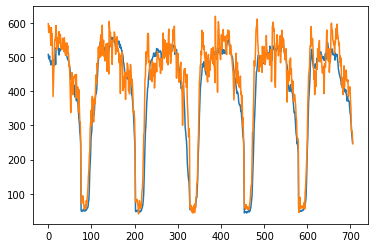

In [13]:
plt.plot(model_pre[:, 5, 4])
plt.plot(label_test_target[:, 5, 4])